In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

Read the dataset (assuming it is located in the same directory as the notebook).

In [2]:
df = pd.read_excel('TG_T_CashValues_Rel.xlsx')

### Exploring the dataset.

Show the first few rows in the dataframe

In [3]:
df.head()

,Gender,Age,Dur,ppv
0,Male,0,20,15.198437
1,Male,0,21,15.741015
2,Male,0,22,16.267189
3,Male,0,23,16.777448
4,Male,0,24,17.272269


Show column names, datatypes along with the count of non-null values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5270 entries, 0 to 5269
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  5270 non-null   object 
 1   Age     5270 non-null   int64  
 2   Dur     5270 non-null   int64  
 3   ppv     5270 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 164.8+ KB


Check for null values

In [5]:
df.isnull().sum()

Gender    0
Age       0
Dur       0
ppv       0
dtype: int64

No null values

Check for inconsistent values

For age, dur (duration), and ppv (pay-per-view), they should be non-negative

In [6]:
df[df['Age'] < 0]

,Gender,Age,Dur,ppv


In [7]:
df[df['Dur'] < 0]

,Gender,Age,Dur,ppv


In [8]:
df[df['ppv'] < 0]

,Gender,Age,Dur,ppv


No inconsistencies

#### Space optimization.

For the Gender attribute, it is a string type, in order to optimize the storage, we can convert it to `category` type if the unique values number is small

In [9]:
df['Gender'].unique()

array(['Male', 'Female'], dtype=object)

As we can see, there are just 2 unique values, so it is good to convert the type to category

In [10]:
df['Gender'] = df['Gender'].astype('category')

Now for `Age` attruibute, check the range of it to see if we can store the values in a smaller datatype (like `int8`) instead of `int64`

In [11]:
df['Age'].describe()

count    5270.000000
mean       31.294118
std        18.671548
min         0.000000
25%        16.000000
50%        30.000000
75%        45.000000
max        80.000000
Name: Age, dtype: float64

As we can see, minimum value is 0 and max value is 80, we can store it in `int8`

In [12]:
df['Age'] = df['Age'].astype('int8')

Do the same for `Dur` attribute.

In [13]:
df['Dur'].describe()

count    5270.000000
mean       22.882353
std        13.793388
min         1.000000
25%        11.000000
50%        22.000000
75%        34.000000
max        50.000000
Name: Dur, dtype: float64

Min = 1, Max = 50 => `int8`

In [14]:
df['Dur'] = df['Dur'].astype('int8')

Now let's see the memory usage.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5270 entries, 0 to 5269
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Gender  5270 non-null   category
 1   Age     5270 non-null   int8    
 2   Dur     5270 non-null   int8    
 3   ppv     5270 non-null   float64 
dtypes: category(1), float64(1), int8(2)
memory usage: 56.9 KB


From 164.8+ KB to 56.9 KB, that's cool!

### Study attributes for outliers. 

Let's discover Outliers in age, dur, and ppv features using box plots.

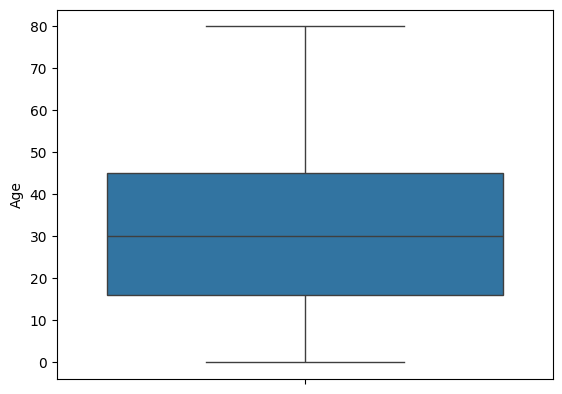

In [16]:
sns.boxplot(data=df['Age']);

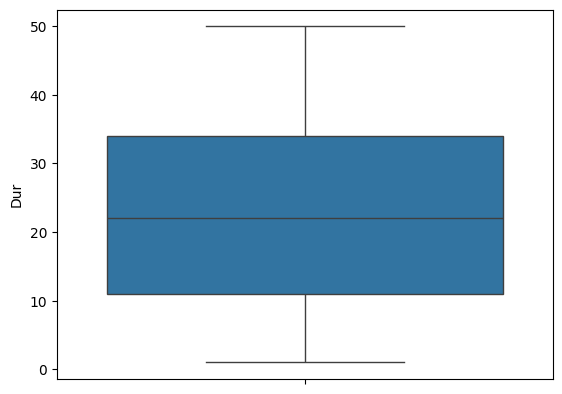

In [17]:
sns.boxplot(data=df['Dur']);

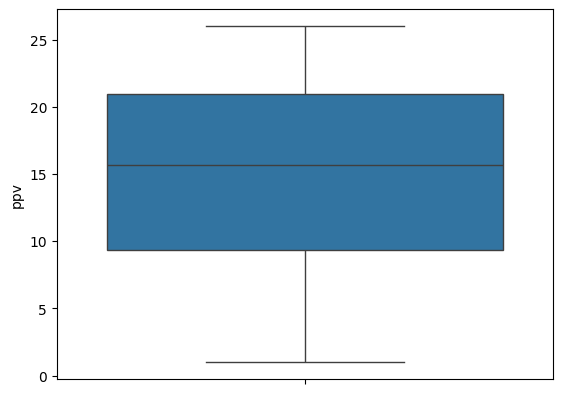

In [18]:
sns.boxplot(df['ppv']);

As we can see, no outliers.

### Feature selection for the prediciton process.

All of the attributes can be relevant somehow to the target (ppv).

Let's do further analysis.

For the numeric features, calculate the correlation between the feature and the target value.

In [19]:
df.corr(numeric_only=True)

,Age,Dur,ppv
Age,1.000000,-0.507243,-0.565087
Dur,-0.507243,1.000000,0.978774
ppv,-0.565087,0.978774,1.000000


As we can see, A high correlation value for the `Dur` attribute and a relatively 'good' value for the `Age` attribute (with `ppv`).

Also note that the correlation between `Age` and `Dur` attributes are not strong enough for them to replace one another. 

We can consider both of them for the prediction process.

We can support our results with a pair plot containing scatter plots for the features.

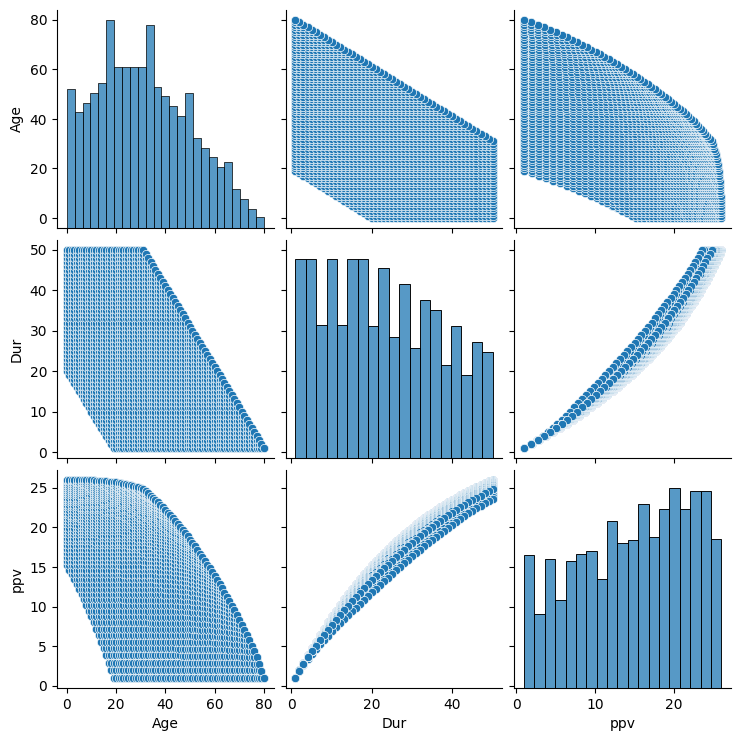

In [20]:
sns.pairplot(df);

For the categorical feature, we can use the ANOVA (ANalysis Of VAriance) as a metric to decide.

Read about ANOVA [here](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/anova/#:~:text=After%20cleaning%20the%20data%2C%20the,the%20alternative%20hypothesis%20is%20supported.)

In [21]:
f_values, p_values = f_classif(pd.get_dummies(df['Gender']), df['ppv'])

print(f_values)
print(p_values)

[0.12075744 0.12075744]
[1. 1.]


The result here supports not considering the `Gender` categorical feature in the prediction process.

### Choosing a Perdiction algorithm

For the context, the size, and the conclusion above of the dataset of our problem, I would consider (after searching) one of these algorithms:
- Linear Regression
- Random Forest Regressor
- Gradient Boosting Regressor

I will choose based on the performance of each algorithm given the dataset (here I will take the MSE (Mean squared error) metric).

If equal values of MSE are detected, the least complex one of the algorithms that has the min. MSE will be chosen.

In [22]:
# features to consider
X = df[['Age', 'Dur']]

In [23]:
# target
y = df['ppv']

In [24]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# a function to get the MSE for a regressor given the X_test and y_test data.
def get_MSE(regressor, X_test, y_test):
    y_pred = regressor.predict(X_test)
    
    return mean_squared_error(y_test, y_pred)

In [26]:
# Regressors to use
regressors = {
    'Linear Regression': LinearRegression(), 
    'Random Forest Regressor': RandomForestRegressor(random_state=42), 
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}

In [27]:
# fit X_train and y_train, calculate the MSE, print the calculated MSE with its corresponding algorithm name, 
# and pick the regressor index with the minimum MSE
mn_MSE = float("infinity")
mn_MSE_name = None

for (name, reg) in regressors.items():
    reg.fit(X_train, y_train)

    mse = get_MSE(reg, X_test, y_test)

    print(f'MSE of {name} regressor = {mse}')

    if mse < mn_MSE:
        mn_MSE_name = name
        mn_MSE = mse

MSE of Linear Regression regressor = 1.6507694667888972
MSE of Random Forest Regressor regressor = 0.1362632764910693
MSE of Gradient Boosting Regressor regressor = 0.07571558316121467


As we can see, `GradientBoostingRegressor` has the min. value of MSE, therefore, it will be chosen.

Everything is ready for this regressor so far, let's predict `ppv` for some sample values.

In [28]:
chosen_regressor = regressors[mn_MSE_name]

In [29]:
# the first sample in the result of df.head()
chosen_regressor.predict(pd.DataFrame([[0, 20]], columns=X.columns))
# A dataframe to ignore the warning appears when a simple list is passed because the datasets used for the prior processes are labeled.

array([15.14048993])

In [30]:
# Let's try another value (from me this time)
chosen_regressor.predict(pd.DataFrame([[15, 30]], columns=X.columns))

array([19.86364557])